<a href="https://colab.research.google.com/github/WeizmannML/course2020/blob/master/Tutorial3/Convolution_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import cv2
import numpy as np
import skimage

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Downloading the image and convert it into gray scale image

In [0]:
!wget https://i1.wp.com/wallur.com/wp-content/uploads/2016/12/tiger-background-3.jpg?w=1920

--2020-05-17 08:28:49--  https://i1.wp.com/wallur.com/wp-content/uploads/2016/12/tiger-background-3.jpg?w=1920
Resolving i1.wp.com (i1.wp.com)... 192.0.77.2
Connecting to i1.wp.com (i1.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344105 (336K) [image/jpeg]
Saving to: ‘tiger-background-3.jpg?w=1920’

tiger-background-3. 100%[===================>] 336.04K  --.-KB/s    in 0.02s   

2020-05-17 08:28:50 (16.7 MB/s) - ‘tiger-background-3.jpg?w=1920’ saved [344105/344105]



In [0]:
!ls -ltr 

total 344
drwxr-xr-x 1 root root   4096 May 13 16:29  sample_data
-rw-r--r-- 1 root root 344105 May 14 18:31 'tiger-background-3.jpg?w=1920'


In [0]:
import skimage.data
# Reading the image
#img = skimage.data.chelsea()
img = mpimg.imread('tiger-background-3.jpg?w=1920')

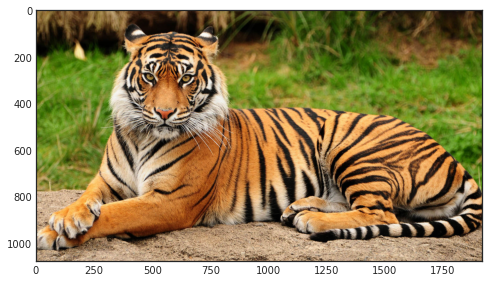

In [0]:
plt.rcParams["figure.figsize"]=8,8
with plt.style.context('seaborn-white'):  
    plt.imshow(img)

In [0]:
skimage.color??

Object `skimage.color` not found.


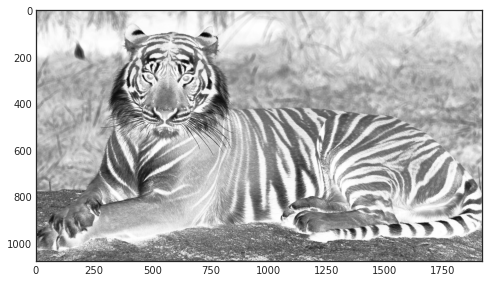

In [0]:
#gray_img = skimage.color.rgb2gray(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.rcParams["figure.figsize"]=8,8
with plt.style.context('seaborn-white'):  
    plt.imshow(gray_img)

In [0]:
img.shape, gray_img.shape

((1080, 1920, 3), (1080, 1920))

## Playing with several filters
### Define the Sobel filter and scan our image

In [0]:
# the filter popular for edge ditection 
# also available through scipy.ndimage.sobel(image)

sobel = np.array([[-1., -2., -1.],
                  [ 0.,  0.,  0.],
                  [ 1.,  2.,  1. ]
                   ])

# filter = np.array([[-1., -1., -1.],
#                    [-1.,  8., -1.],
#                    [-1., -1., -1. ]
#                    ])

In [0]:
##cv2.filter2D??

### $ [\texttt{dst} (x,y) =  \sum _{ \stackrel{0\leq x' < \texttt{kernel.cols},}{0\leq y' < \texttt{kernel.rows}} }  \texttt{kernel} (x',y')* \texttt{src} (x+x'- \texttt{anchor.x} ,y+y'- \texttt{anchor.y} )]$

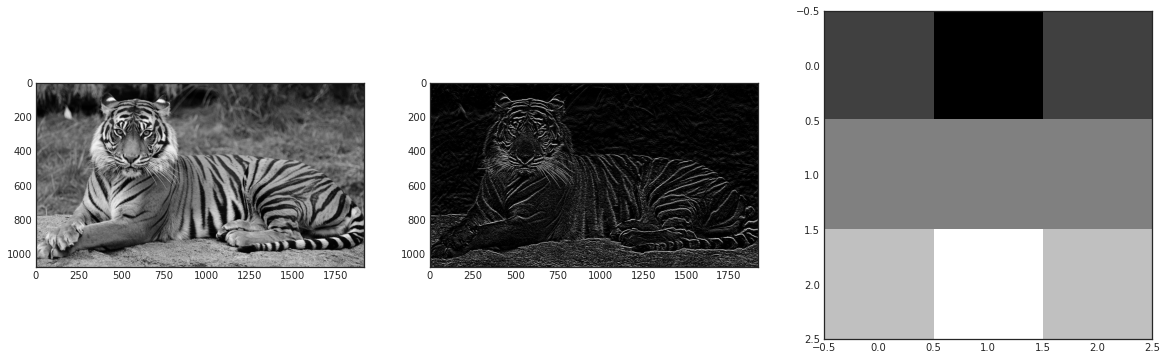

In [0]:
filtered_gray_img = cv2.filter2D(gray_img, -1, sobel)


# ----- compare the plots ------ #
plt.rcParams["figure.figsize"]=20,25
with plt.style.context('seaborn-white'):
    plt.subplot(331)
    plt.imshow(gray_img, cmap='gray')
    plt.subplot(332)
    plt.imshow(filtered_gray_img, cmap='gray')
    plt.subplot(333)
    plt.imshow(sobel, cmap='gray')

plt.show()

In [0]:
gray_img.shape, filtered_gray_img.shape

((1080, 1920), (1080, 1920))

### How should the 2-D convolution operation look like in terms of basic numpy ?

In [0]:
def conv2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum() ## -- replace .sum() by .max(), .mean() for maxpooling & average pooling respectively
    return Y

In [0]:
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = np.array([[0, 1], [2, 3]])
conv2d(X, K)

array([[19., 25.],
       [37., 43.]])

### What if the input image is multi-channeled ?

In [0]:
def conv2d_multi(X, K):

    return sum(conv2d(x, k) for x, k in zip(X, K))

In [0]:
X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = np.array([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

conv2d_multi(X, K)

array([[ 56.,  72.],
       [104., 120.]])

In [0]:
def conv2d_multi_in_out(X, K):
    # Traverse along the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are merged
    # together using the stack function
    return np.stack([conv2d_multi(X, k) for k in K])

In [0]:
K_M = np.stack((K, K + 1, K + 2))
K_M.shape

(3, 2, 2, 2)

In [0]:
conv2d_multi_in_out(X, K_M)

array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

In [0]:
x = np.array([1, 2, 3])
x.max(), x.min(), x.mean()

(3, 1, 2.0)

### Let's bring in pytorch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable

In [0]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [0]:
##nn.Conv2d??

$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$

###def \__init__(self, in_channels, out_channels, kernel_size, stride=1,      padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')


In [0]:
conv2d_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=(4,4) ) # --- declare a Conv2D layer to give 3 output channels --- #

In [0]:
image_shape = img.shape
print( 'Original shape : ', image_shape )

new_shape = tuple( [1] + list(image_shape) )

print( 'New shape : ', new_shape )


image1 = img.reshape(new_shape ).transpose(0,3,1,2)


#np.reshape(image, new_shape)

#print(image1.shape)
image1 = conv2d_layer1(  torch.from_numpy(image1).type('torch.FloatTensor')  )
print( 'Shape after convolution: ', image1.shape)
#print(image1.view(3, 2382, 1589).shape)

Original shape :  (1080, 1920, 3)
New shape :  (1, 1080, 1920, 3)
Shape after convolution:  torch.Size([1, 3, 1077, 1917])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


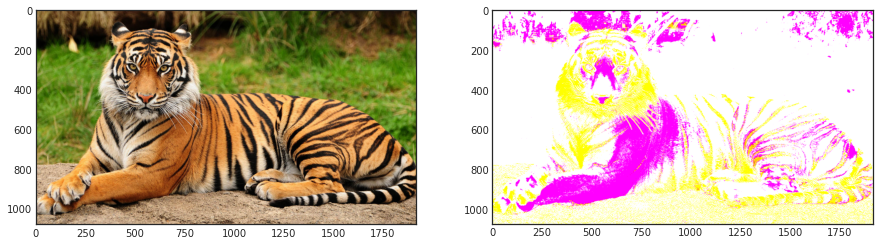

In [0]:
# ----- compare the plots ------ #
plt.rcParams["figure.figsize"]=15,20
with plt.style.context('seaborn-white'):
    plt.subplot(221)
    plt.imshow(img)
    plt.subplot(222)
    plt.imshow(image1.view(3, 1077, 1917).detach().numpy().transpose(1,2,0)  )
#     plt.subplot(333)
#     plt.imshow(sobel, cmap='gray')

plt.show()

### Let's have a look into the random weights of the convolutional layer

In [0]:
weight = conv2d_layer1.weight.data.numpy()
weight.shape

(3, 3, 4, 4)

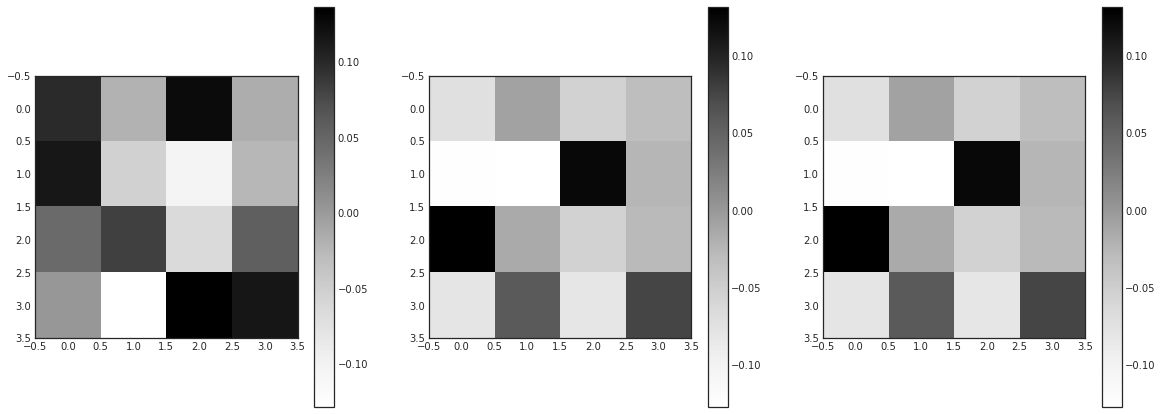

In [0]:
plt.rcParams["figure.figsize"]=20,25
with plt.style.context('seaborn-white'):
  
    plt.subplot(331)
    plt.imshow(weight[0][0])
    plt.colorbar()
    plt.subplot(332)
    plt.imshow(weight[1][0])
    plt.colorbar()
    plt.subplot(333)
    plt.imshow(weight[1][0])
    plt.colorbar()
    
plt.show()


#### Dataset at : https://www.dropbox.com/preview/ML%20Course%202020/Tutorial3/Malaria_Images.zip?role=work

In [0]:
from google.colab import files
files.upload()

Saving Malaria_Images.zip to Malaria_Images.zip


In [0]:
!ls -ltr 

total 32812
drwxr-xr-x 1 root root     4096 May  4 16:26  sample_data
-rw-r--r-- 1 root root   344105 May 14 18:31 'tiger-background-3.jpg?w=1920'
-rw-r--r-- 1 root root 33241131 May 14 20:05  Malaria_Images.zip


In [0]:
!unzip Malaria_Images.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Malaria_Images/Parasitized/._C48P9thinF_IMG_20150721_162732_cell_27.png  
  inflating: Malaria_Images/Parasitized/C48P9thinF_IMG_20150721_164129_cell_27.png  
  inflating: __MACOSX/Malaria_Images/Parasitized/._C48P9thinF_IMG_20150721_164129_cell_27.png  
  inflating: Malaria_Images/Parasitized/C39P4thinF_original_IMG_20150622_105803_cell_112.png  
  inflating: __MACOSX/Malaria_Images/Parasitized/._C39P4thinF_original_IMG_20150622_105803_cell_112.png  
  inflating: Malaria_Images/Parasitized/C39P4thinF_original_IMG_20150622_114804_cell_41.png  
  inflating: __MACOSX/Malaria_Images/Parasitized/._C39P4thinF_original_IMG_20150622_114804_cell_41.png  
  inflating: Malaria_Images/Parasitized/C48P9thinF_IMG_20150721_164129_cell_33.png  
  inflating: __MACOSX/Malaria_Images/Parasitized/._C48P9thinF_IMG_20150721_164129_cell_33.png  
  inflating: Malaria_Images/Parasitized/C39P4thinF_original_IMG_20150622_105803_cell_106.pn

In [0]:
!ls -a 

 .    .config	 Malaria_Images       sample_data
 ..   __MACOSX	 Malaria_Images.zip  'tiger-background-3.jpg?w=1920'


In [0]:
!rm -rf __MACOSX/

### Let's visualize the dataset.
#### We will use fastai library for visualization purpose only

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [0]:
!ls -a  Malaria_Images

.  ..  .DS_Store  Parasitized  Uninfected


In [0]:
img_path = Path('./Malaria_Images/')

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(img_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['Parasitized', 'Uninfected']

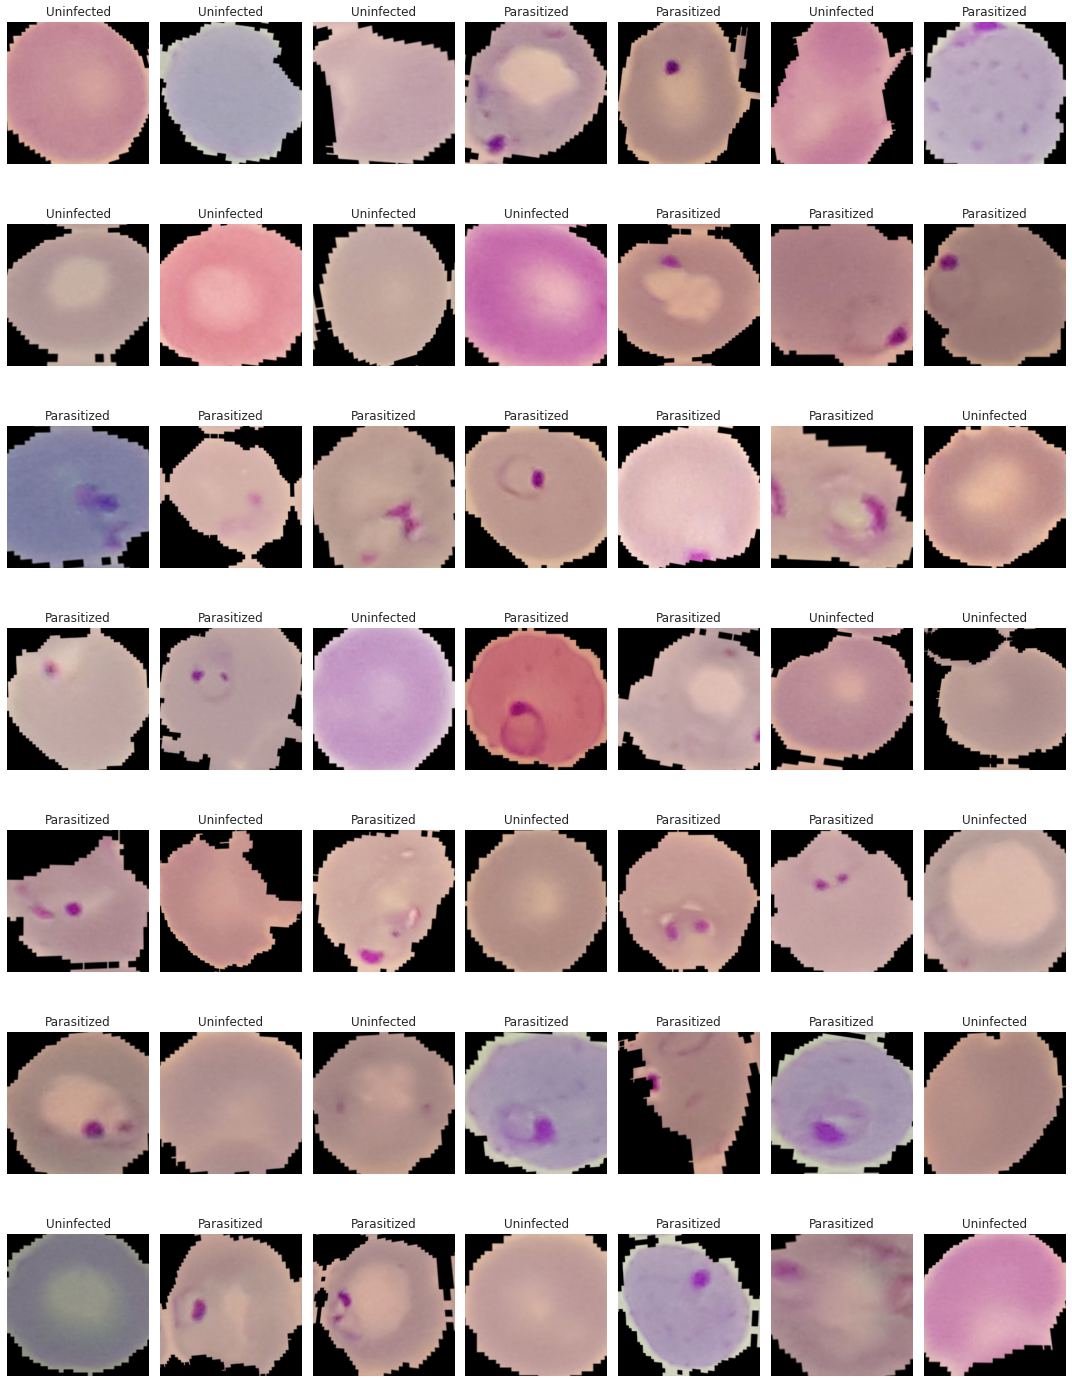

In [0]:
with plt.style.context('seaborn-white'):
     data.show_batch(rows=7, figsize=(15,20))

### Build the model out of Conv2D, ReLu : ----> Liner ----- > # of classes¶

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,16,kernel_size=4)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv2=nn.Conv2d(16,32,kernel_size=(4,4))
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv3=nn.Conv2d(32,64,kernel_size=(4,4))
        self.pool3=nn.MaxPool2d(kernel_size=(4,4),stride=2)
        self.fc1=nn.Linear(4*4*64,500)
        self.fc2=nn.Linear(500,100)
        self.fc3=nn.Linear(100,2)
        self.dropout=nn.Dropout(0.3)
        
    def forward(self, x):
        
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.dropout(x)
        x=self.pool2(F.relu(self.conv2(x)))
        x=self.dropout(x)
        x=self.pool3(F.relu(self.conv3(x)))
        x=self.dropout(x)
        x=x.reshape( -1,4*4*64)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.fc3(x)
        return x
      
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.pool1(x)
        
#         x=self.dropout(x)
        
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.pool2(x)
        
#         x=self.dropout(x)
        
#         x = self.conv3(x)
#         x = F.relu(x)
#         x = self.pool3(x)
        
#         x=self.dropout(x)
        
#         x=x.reshape( -1,4*4*64)
        
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout(x)
        
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.dropout(x)
        
#         x=self.fc3(x)
#         return x

In [0]:
##Design a  preprocessor using pytorch functions ###

train_transforms = transforms.Compose([transforms.RandomResizedCrop(64), ## crops the image suitable, later returns same aspect ratio
                                       transforms.ToTensor(),            ## turns the image : numpy-tensor to torch tensor
                                       transforms.Normalize([0.5, 0.5, 0.5], ## applies normalization on each channel ---- mean, sigma ----
                                                            [0.5, 0.5, 0.5])
                                       
                                       ])

### The pytorch dataloader 

In [0]:
img_dir='./Malaria_Images/'
data = torchvision.datasets.ImageFolder(img_dir,transform=train_transforms) ## read the input images and apply pre-defined transformation --

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(f'val_index: {len(valid_idx)},test_index: {len(test_idx)},train_index: {len(train_idx)}')

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(data, batch_size=101,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=33, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(data, batch_size=106,
    sampler=test_sampler, num_workers=num_workers)

val_index: 534,test_index: 267,train_index: 1871


In [0]:
model_cnn = Net()
loss_func = nn.CrossEntropyLoss()

In [0]:
print(model_cnn)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [0]:
if torch.cuda.is_available():
    model_cnn = model_cnn.cuda()

In [0]:
### ----- Define the optimizer here ------ ###
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001)
total_step = len(train_loader)

In [0]:

# number of epochs to train the model
n_epochs = 100
train_loss_v, valid_loss_v = [], []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model_cnn.train() ## --- set the model to train mode -- ##
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_cnn(data)
        # calculate the batch loss
        loss = loss_func(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()#*data.size(0)
        
#         if (epoch) % 2 == 0:
#             print ('Epoch [{}/{}], Loss: {:.4f}' 
#                    .format(epoch, n_epochs, loss.item()))
        
    ######################  
    
    
    
    ######################    
    # validate the model #
    ######################
    model_cnn.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_cnn(data)
        # calculate the batch loss
        loss = loss_func(output, target)
        # update average validation loss 
        valid_loss += loss.item()#*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    train_loss_v.append(train_loss) 
    valid_loss_v.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_cnn.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.004070 	Validation Loss: 0.003815
Validation loss decreased (inf --> 0.003815).  Saving model ...
Epoch: 2 	Training Loss: 0.004031 	Validation Loss: 0.003791
Validation loss decreased (0.003815 --> 0.003791).  Saving model ...
Epoch: 3 	Training Loss: 0.003926 	Validation Loss: 0.003616
Validation loss decreased (0.003791 --> 0.003616).  Saving model ...
Epoch: 4 	Training Loss: 0.003873 	Validation Loss: 0.003632
Epoch: 5 	Training Loss: 0.003673 	Validation Loss: 0.003460
Validation loss decreased (0.003616 --> 0.003460).  Saving model ...
Epoch: 6 	Training Loss: 0.003547 	Validation Loss: 0.003333
Validation loss decreased (0.003460 --> 0.003333).  Saving model ...
Epoch: 7 	Training Loss: 0.003541 	Validation Loss: 0.003362
Epoch: 8 	Training Loss: 0.003374 	Validation Loss: 0.003180
Validation loss decreased (0.003333 --> 0.003180).  Saving model ...
Epoch: 9 	Training Loss: 0.003324 	Validation Loss: 0.003312
Epoch: 10 	Training Loss: 0.003225 	Valida

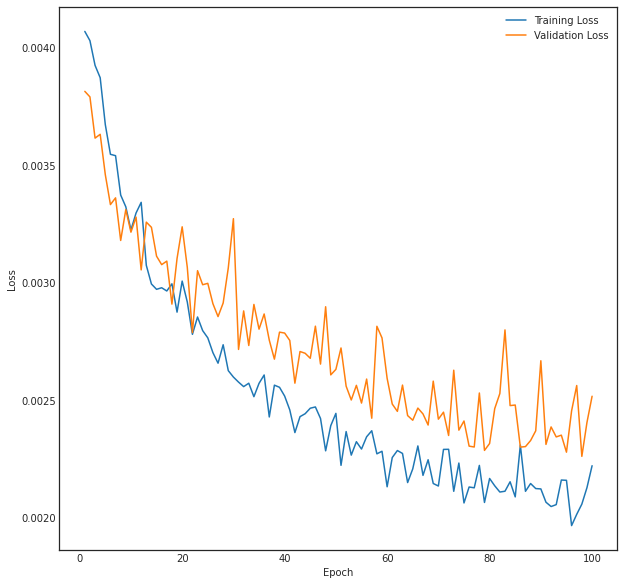

In [0]:
plt.rcParams["figure.figsize"]=10,10
with plt.style.context('seaborn-white'):
  plt.plot( range(1, n_epochs+1), np.array(train_loss_v), label='Training Loss' )
  plt.plot( range(1, n_epochs+1), np.array(valid_loss_v), label='Validation Loss' )
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
plt.show()

### Check the performance of the training

In [0]:
# Test the model
model_cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():  # the gradient computation is off .. saves memory while doing the eval #
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 82.77153558052434 %


### See the state of the model after these epochs of training

In [0]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_cnn.state_dict():
    print(param_tensor, "\t", model_cnn.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 4, 4])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 4, 4])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 4, 4])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([500, 1024])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([100, 500])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([2, 100])
fc3.bias 	 torch.Size([2])


In [0]:
model_state_dict = model_cnn.state_dict()

In [0]:
model_state_dict.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [0]:
model_state_dict['conv1.weight'].shape  # model_state_dict['conv1.weight'] returns you all the trained weights of conv1 layer

torch.Size([16, 3, 4, 4])

In [0]:
child_counter = 0
for child in model_cnn.children():
    print(" child", child_counter, "is -")
    print(child)
    child_counter += 1

 child 0 is -
Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
 child 1 is -
MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
 child 2 is -
Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
 child 3 is -
MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
 child 4 is -
Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
 child 5 is -
MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
 child 6 is -
Linear(in_features=1024, out_features=500, bias=True)
 child 7 is -
Linear(in_features=500, out_features=100, bias=True)
 child 8 is -
Linear(in_features=100, out_features=2, bias=True)
 child 9 is -
Dropout(p=0.3, inplace=False)


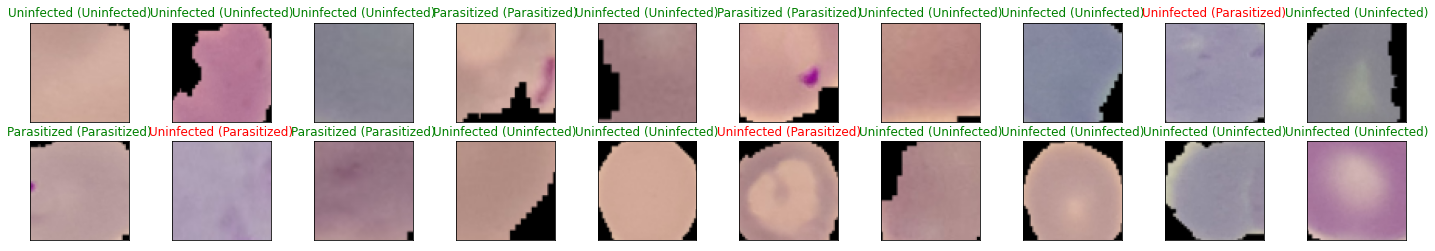

In [0]:
classes = ['Parasitized', 'Uninfected']

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model_cnn(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))